This notebook implements a light-weight version of an ICLR'23 paper system: REACT (https://react-lm.github.io)

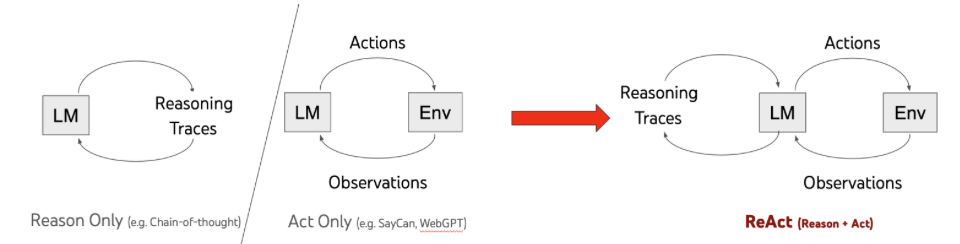

In [20]:
from llm_challenge.utils.misc import read_dict_from_json, \
                                     set_openai_api_key, \
                                     write_dict_to_json, \
                                     get_completion, \
                                     read_text
from pathlib import Path
from tqdm import tqdm
import time
import numpy as np
import openai

In [21]:
set_openai_api_key()

In [22]:

dset = "tutorial"
DATA_DIR = "../data"

qas_dict = read_dict_from_json(f"{DATA_DIR}/qas/qas_{dset}.json")
doc_fnames = list(set([DATA_DIR + "/datasheets/" + datum["datasheet"]  for datum in qas_dict.values()]))
module_names = [_.split('/')[-1][:-4] for _ in doc_fnames]

#### REACT



In [23]:
instruction = """Solve a question answering task about datasheets with interleaving Thought, Action, Observation steps. 
Thought can reason about the current situation, and Action can be five types: 
(1) Search[`module_name`], which searches for the name of electrical/electronic component `module_name` mentioned in the question. If not, it will return UNK.
(2) Annotate, which lists no more than three keywords that distinctively describe the `question`.
(3) LookupKeywords, which returns a piece of text containing the list of keywords.
(4) Reason, which provides a response to the `question` based on the returned text.
(5) Finish, which returns the response (from reasoning step) and finishes the task if answer is known or not.
Here is one example.
"""

examples = """
Question: What is the purpose of the Conditional Search ROM command in the DS28E04-100 module?
Thought 1: I need to find the datasheet of the DS28E04-100 module.
Action 1: Search[DS28E04-100]
Observation 1: datasheet found.
Thought 2: Now I need to look up the paragraph that talks about Conditional Search ROM command. Let me provide some keywords to find this paragraph.
Action 2: Annotate
Observation 2: Conditional Search, ROM, command
Thought 3: Let me look up the paragraph that contains these keywords
Action 3: LookupKeywords
Observation 3: Relevant text found.
Thought 4: Now I need to reason about the question given the found text.
Action 4: Reason
Observation 4: The purpose of the Conditional Search ROM command in the DS28E04-100 module is to allow the bus master to identify devices on a multidrop system that fulfill certain conditions (CSR = 1) and have to signal an important event. Only those devices that fulfill the conditions will participate in the search. After each pass of the conditional search that successfully determined the 64-bit ROM code for a specific device on the multidrop bus, that particular device can be individually accessed as if a Match ROM had been issued, since all other devices will have dropped out of the search process and will be waiting for a reset pulse.
Thought 5: I think this answers the question.
Action 5: Finish

Start...

Question: {question}
"""

In [24]:
def annotate_question(question):
    prompt = """
    I will give you a question about an electrical/electronic module's datashet delimted by ---
    Your task is to generate a list of keywords that best annotates the question
    
    Here is an example:
    Question: What is the purpose of the Conditional Search ROM command in the DS28E04-100 module
    Keywords: Conditional Search, ROM, command

    Here is the question:
    ---
    {question}
    ---
    Keywords:
    """
    response = get_completion(prompt.format(question=question), stop="\n")  
    return response


def translate_response(response):
    prompt = """
    I will give you a piece of text that represents an answer to a question.
    I want you to reply with one letter either Y or N.
    Y - if the text indicates that the question cant be answered.
    N - if the text represents a potential answer to the question.
    
    Here is the text
    ```
    {text}
    ```
    output Y or N as outlined earlier:
    """
    is_idk = get_completion(prompt.format(text=response), stop="\n")
    #print(response)
    #print(f"translating response: is_idk={is_idk}")
    if is_idk == 'Y' or 'IDK' in response:
        return 'I do not know.'
    else:
        return response

def reason_given_context(question, contexts):
    prompt = """
    I will give you a peice of text from electrical/electronic module's datashet delimted by ---
    Your task is to either to give a detailed answer to the question that follows the text 
    based on the provided text or say `IDK` if the text does not contain sufficient information.
    Here is the text:
    ---
    {text}
    ---
    Question: {question}
    Answer/Output `IDK` if you cant answer:
    """
    for idx, context in enumerate(contexts):
        print(f"reasoning attempt {idx}")
        response = get_completion(prompt.format(text=context.replace("\n"," "), question=question), stop="\n")
        response = translate_response(response)
        #print(response)
        if 'I do not know.' not in response: break
        if idx > 10: break
    return response
    
def get_embedding(text, model="text-embedding-ada-002"):
    text = text.replace("\n", " ")
    return np.array(openai.Embedding.create(input = [text], model=model)['data'][0]['embedding'])
    
def lookup_keywords(module_name, doc_idx, keywords):
    if doc_idx > -1:
        candidate_text = read_text(doc_fnames[doc_idx])
    else:
        candidate_texts = [text for text in texts \
                           if np.any([kw in text for kw in keywords])\
                          ]
        candidate_text = " ".join(candidate_texts)
    context_window = 5000
    candidate_texts = [candidate_text[i:i+context_window] for i in range(0, len(candidate_text), context_window)]
    #print(len(candidate_texts))
    if len(candidate_texts) > 0:
        return candidate_texts, "Relevant text found."
    else:
        return candidate_texts, "No relevant text found."


def search_datasheet(module_name):
    #print(module_name)
    try:
        module_number = re.sub('\D','', module_name)
        #print(module_number)
        candidate_modules = [module_name for module_name in module_names if module_number in module_name] 
        # pick first module for now...
        module_idx = module_names.index(candidate_modules[0])
    except ValueError:
        module_idx = -1
    return f"datasheet{'' if module_idx > -1 else ' not'} found\n""", module_idx

In [25]:
from typing import List, Optional

class ReactAgent:
    observations: List[str] = []
    keywords: List[str] = []
    doc_idx: int = 0
    module_name: str = """"""
    instruction: str = """"""
    examples: str = """"""
    prompt: str = """"""
    answer: str = """"""
    
    def __init__(self,instruction: str, examples: str):
        self.instruction = instruction
        self.examples = examples
        self.reset()
        
    def reset(self):
        self.prompt = self.instruction + self.examples
        self.observations = []
        
        
    @property
    def observation_num(self):
        return len(self.observations) + 1
    
    def append_observation(self,observation):
        observation = f"Observation {self.observation_num}: " + observation
        self.observations.append(observation)
        
    def update_prompt(self, message):
        message = message.replace('\n','')
        #print("Updating prompt with ...")
        print(message)
        self.prompt = self.prompt + '\n' + message + '\n'
    
    def process_response(self, response) -> bool:
        #print(response)
        try:
            self.is_successful = True
            if response.startswith("Action"):
                action = response.split(': ')[-1]
                if action.startswith("Finish"):
                    return True
                elif action.startswith("Search["):
                    self.module_name = action.split('[')[-1][:-1]
                    observation, doc_idx = search_datasheet(self.module_name)
                    self.doc_idx = doc_idx
                elif action.startswith("Annotate"):
                    observation = annotate_question(self.question)
                    self.keywords = observation.split(',')
                elif action.startswith("LookupKeywords"):
                    contexts, observation = lookup_keywords(self.module_name, self.doc_idx, self.keywords)
                    self.contexts = contexts
                elif action.startswith("Reason"):
                    observation = reason_given_context(self.question, self.contexts)
                    self.answer = observation

                self.append_observation(observation)
                self.update_prompt(response)
                self.update_prompt(self.observations[-1])

            elif response.startswith("Thought"):
                self.update_prompt(response)
            
            return False
        
        except Exception as e:
            print(e)
            self.is_successful = False
            return True
        
    def generate_answer(self,question):
        self.question = question
        self.update_prompt(question)
        response = get_completion(self.prompt, stop="\n")
        while not self.process_response(response):
            time.sleep(0.1)
            response = get_completion(self.prompt, stop="\n")
            
        if self.is_successful:
            return self.answer
        else:
            return "I do not know."
    

In [26]:
agent = ReactAgent(instruction=instruction, examples=examples)

In [27]:
agent.generate_answer("What is the recommended range for the value of C1 in the LTC7804 module and why is it chosen in that range?")

What is the recommended range for the value of C1 in the LTC7804 module and why is it chosen in that range?
Thought 1: I need to find the datasheet of the LTC7804 module.
Action 1: Search[LTC7804]
Observation 1: datasheet found
Thought 2: Now I need to look up the paragraph that talks about the recommended range for the value of C1.
Action 2: Annotate
Observation 2: recommended range, value, C1, LTC7804 module, chosen
Thought 3: Let me look up the paragraph that contains these keywords.
Action 3: LookupKeywords
Observation 3: Relevant text found.
Thought 4: Now I need to reason about the question given the found text.
reasoning attempt 0
reasoning attempt 1
reasoning attempt 2
reasoning attempt 3
reasoning attempt 4
reasoning attempt 5
reasoning attempt 6
reasoning attempt 7
reasoning attempt 8
Action 4: Reason
Observation 4: The recommended range for the value of C1 in the LTC7804 module is 0.1μF to 0.47μF. It is chosen in this range to reduce error that might have been caused by the 

"The recommended range for the value of C1 in the LTC7804 module is 0.1μF to 0.47μF. It is chosen in this range to reduce error that might have been caused by the SENSE− pin's ±1μA current."